## Investment Case Group Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dirpath = 'C:/Users/ankit.bhatia/Documents/GitHub/PythonScripts/data/spark_funds/'
file1 = 'companies.txt'
file2 = 'rounds2.csv'
file3 = 'mapping.csv'

In [2]:
companies = pd.read_csv(dirpath+file1,sep='\t',encoding='iso-8859-1')
rounds2 = pd.read_csv(dirpath+file2,encoding='iso-8859-1') # Use 'iso-8859-1' for accented characters

In [3]:
companies.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN


In [4]:
rounds2.head(3)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0


### Table 1.1
#### Q1. How many unique companies are present in rounds2?

In [5]:
# Normal Count
#rounds2.company_permalink.count()

# Unique count which excludes NA as well by default
rounds2.company_permalink.nunique()

90247

#### Q2. How many unique companies are present in companies?

In [6]:
companies.permalink.nunique()

66368

#### Q3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

In [7]:
# Ist Method
#nunique() will give unique values for each column, column with maximum unique counts can be considered as unique column#### 
companies.nunique().sort_values(ascending=False).iloc[0:1]

# IInd Method
# Companies.describe() will give count, unique, top etc information, we store count & unique values in a temp df and
# then subtracting unique values(1) from count(0) and giving the column name where difference is 0
#companies.describe().iloc[0:2]


permalink    66368
dtype: int64

#### Q4. Are there any companies in the rounds2 file which are not  present in companies ?

In [8]:
# Check the existacce of a column of dataframe1 in column1 of dataframe2
rounds2[rounds2['company_permalink'].str.lower().isin(companies['permalink'].str.lower())== False]

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
29597,/ORGANIZATION/E-CÃBICA,/funding-round/8491f74869e4fe8ba9c378394f8fbdea,seed,NaN,01-02-2015,NaN
31863,/ORGANIZATION/ENERGYSTONE-GAMES-ÇµÇ³Æ¸¸Æ,/funding-round/b89553f3d2279c5683ae93f45a21cfe0,seed,NaN,09-08-2014,NaN
45176,/organization/huizuche-com-æ ç§ÿè½¦,/funding-round/8f8a32dbeeb0f831a78702f83af78a36,seed,NaN,18-09-2014,NaN
58473,/ORGANIZATION/MAGNET-TECH-Ç£Ç³Ç§Æ,/funding-round/8fc91fbb32bc95e97f151dd0cb4166bf,seed,NaN,16-08-2014,1625585.0
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,/funding-round/41005928a1439cb2d706a43cb661f60f,seed,NaN,06-09-2010,NaN
109969,/ORGANIZATION/WEICHE-TECH-ÅÈ½¦Ç§Æ,/funding-round/f74e457f838b81fa0b29649740f186d8,venture,A,06-09-2015,NaN
113839,/ORGANIZATION/ZENGAME-Ç¦ Æ¸¸Ç§Æ,/funding-round/6ba28fb4f3eadf5a9c6c81bc5dde6cdf,seed,NaN,17-07-2010,NaN


#### Q5. Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame ?

In [9]:
# lower() the key columns of both dataframes, so they can match in case of diffence in case.
companies['permalink'] = companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
master_frame = pd.merge(left = companies,right = rounds2, how ='inner', left_on='permalink',right_on='company_permalink')
master_frame.shape[0]

# From here we will work with master_frame only

114942

### Table 2.1 ( Average Values of Investments for Each of these Funding Types)
#### Q1/2/3/4. Average funding amount of different funding type ?

venture 11748949.129489528
angel 958694.4697530865
seed 719779.6202016778
private_equity 73308593.02944215


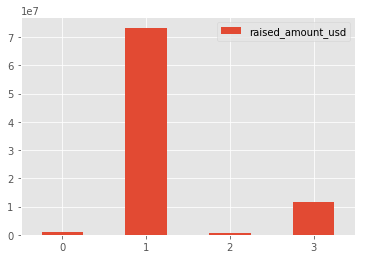

In [65]:
def avg_funding_amount(funding_type):
    return master_frame[master_frame['funding_round_type']==funding_type]['raised_amount_usd'].mean()

venture = avg_funding_amount('venture')
angel = avg_funding_amount('angel')
seed = avg_funding_amount('seed')
private_equity = avg_funding_amount('private_equity')

print('venture' ,avg_funding_amount('venture'))
print('angel' ,avg_funding_amount('angel'))
print('seed' ,avg_funding_amount('seed'))
print('private_equity' ,avg_funding_amount('private_equity'))


p = master_frame[master_frame['funding_round_type'].isin(['venture','angel','seed','private_equity'])]

p = p.groupby(by='funding_round_type')['raised_amount_usd'].mean().reset_index()

p


plt.style.use('ggplot')

ax = p.plot(kind='bar', rot=0)

ax.yaxis.grid(True)

#### Q5. Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?

In [11]:
## [['']] double brackets are used to keep the dataframe , if we use [''], it will be converted into series
most_suitable = master_frame.groupby(by='funding_round_type')[['raised_amount_usd']].mean()
most_suitable = most_suitable[(most_suitable.raised_amount_usd >= 5000000) & (most_suitable.raised_amount_usd <= 15000000)]
most_suitable

,raised_amount_usd
funding_round_type,
venture,1.174895e+07


In [12]:
# Filter the master_frame dataset based on the above conditions(funding_round_type)
master_frame_filtered = master_frame[master_frame.funding_round_type == most_suitable.index[0]]
master_frame_filtered.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0


### Table 3.1 ( Analysing the Top 3 English-Speaking Countries)

In [13]:
top9 = master_frame_filtered.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False)[0:9]
# combined top9.index[0:3]
top = top9.index[0]
top9

country_code
USA    4.225108e+11
CHN    3.983542e+10
GBR    2.024563e+10
IND    1.439186e+10
CAN    9.583332e+09
FRA    7.259537e+09
ISR    6.907515e+09
DEU    6.346960e+09
JPN    3.363677e+09
Name: raised_amount_usd, dtype: float64

In [14]:
# Now the requirement is to fetch top 3 countries from top 9 dataframe where official language is English, we will fetch this 
# information from MySQl > world database > country & country language table. Alternatively we can check this information
# from the pdf provided, but there we have to hardcode the information.
# Note : To match the countries in the countrylanguage table data with pdf data, I have inserted one entry of IND with
# official language is English.
# installed mysql using conda install -c anaconda mysql-connector-python

import mysql.connector as con
db_connection = con.connect(host='localhost', database='world', user='root', password='mysql@123')
query = 'select code,name from country where code in(SELECT countrycode FROM COUNTRYLANGUAGE WHERE LANGUAGE=%s AND ISOFFICIAL=%s)'
countryEN =  pd.read_sql(sql =query,con =db_connection,params=['English','T'])
countryEN.head()
top3 = top9.index[top9.index.isin(countryEN['code'])][0:3]
top3

Index(['USA', 'GBR', 'IND'], dtype='object', name='country_code')

#### Q1/2/3. Top/Second/Third English speaking country ?

In [15]:
top = top3[0]
second = top3[1]
third = top3[2]
print('top ',top)
print('second ',second)
print('third ',third)

top  USA
second  GBR
third  IND


In [16]:
# Filter companies dataset based on top 3 english speaking countries
master_frame_filtered = master_frame_filtered.loc[master_frame_filtered.country_code.isin(top3)]
master_frame_filtered.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,NaN


### Table 5.1 ( Sector-wise Investment Analysis)

In [17]:
# first string before the | will be considered the primary sector.
# Add the new column in companies_filtered dataframe named as 'primary_sector'
master_frame_filtered['primary_sector'] = master_frame_filtered['category_list'].str.split('|').str.get(0)
master_frame_filtered.head(3)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,Media
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,Application Platforms
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,NaN,Software


In [18]:
mapping =  pd.read_csv(dirpath+file3,encoding='iso-8859-1') # Use 'iso-8859-1' for accented characters
mapping.head(3)

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0


In [19]:
# Defining function demap, which will convert data in mapping dataframe above to two columns output.
def demap(df):
    l = list()
    c = int(df.count().sort_values(ascending=False)[0])
    for i in range(c):
        for col_name in df.columns:
            if df[col_name][i]==1:
               l.append(col_name)
    df2 = df.copy()
    df2['final_value'] = l
    return df2.iloc[:,[0,-1]]

In [20]:
mapping_new = demap(mapping)
mapping_new.head()

,category_list,final_value
0,NaN,Blanks
1,3D,Manufacturing
2,3D Printing,Manufacturing
3,3D Technology,Manufacturing
4,Accounting,"Social, Finance, Analytics, Advertising"


In [21]:
master_frame_sector_wise = pd.merge(left=master_frame_filtered, right=mapping_new,left_on='primary_sector',right_on='category_list')
# Drop unnecessary columns
master_frame_sector_wise.drop(labels=['category_list_x', 'category_list_y'],axis=1, inplace=True)
# Rename Columns
master_frame_sector_wise.rename(columns={'final_value':'main_sector'}, inplace=True)

In [22]:
master_frame_sector_wise.head(3)

,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,Media,Entertainment
1,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.0,Media,Entertainment
2,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.0,Media,Entertainment


Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. 
The three data frames should contain:
All the columns of the master_frame along with the primary sector and the main sector
The total number (or count) of investments for each main sector in a separate column
The total amount invested in each main sector in a separate column

In [23]:
#USA
D1 = master_frame_sector_wise[master_frame_sector_wise['country_code']==top]

#GBR
D2 = master_frame_sector_wise[master_frame_sector_wise['country_code']==second]

#IND
D3 = master_frame_sector_wise[master_frame_sector_wise['country_code']==third]

D3.head(3)

,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,Media,Entertainment
23,/organization/manas-informatics,Manas Informatic,http://www.topnews.in,operating,IND,23,Mohali,Mohali,05-05-2007,/organization/manas-informatics,/funding-round/719e50301803d3918ffa558fc877e41c,venture,NaN,02-02-2008,160000.0,Media,Entertainment
244,/organization/ameyo,Ameyo,http://www.ameyo.com/,operating,IND,10,New Delhi,Gurgaon,01-01-2003,/organization/ameyo,/funding-round/81b50a403d5d2293715fe9b0ce4db5d3,venture,A,03-07-2015,5000000.0,Software,Others


#### Q1. Total number of Investments (count)

In [24]:
print(D1.count()[0])
print(D2.count()[0])
print(D3.count()[0])

35759
2158
898


 #### Q2. Total amount of investment (USD)

In [25]:
print(D1.raised_amount_usd.sum())
print(D2.raised_amount_usd.sum())
print(D3.raised_amount_usd.sum())

394680394849.0
19097204731.0
13668331235.0


In [26]:
# Define function to get top sectors count and name
def getSector(dataset,n,identifier):
    # dataset     :: datframe
    # n           :: n represents nth order, 0 for top, 1 for second top and so on.
    # identifier  :: identifier = 'count' to get the count, identifier = 'name' to get the sector name.
    if identifier == 'name':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False).index[n])
    elif identifier == 'count':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False)[n])

#### Q3. Top sector (based on count of investments)

In [27]:
D1_sec0_name = getSector(dataset=D1,n=0,identifier='name')
D2_sec0_name = getSector(D2,0,'name')
D3_sec0_name = getSector(D3,0,'name')

print('D1_sec0_name : ',D1_sec0_name,'\nD2_sec0_name : ',D2_sec0_name,'\nD3_sec0_name : ',D3_sec0_name)

D1_sec0_name :  Others 
D2_sec0_name :  Others 
D3_sec0_name :  Others


#### Q4. Second-best sector (based on count of investments)

In [28]:
D1_sec1_name = getSector(D1,1,'name')
D2_sec1_name = getSector(D2,1,'name')
D3_sec1_name = getSector(D3,1,'name')

print('D1_sec1_name : ',D1_sec1_name,'\nD2_sec1_name : ',D2_sec1_name,'\nD3_sec1_name : ',D3_sec1_name)

D1_sec1_name :  Cleantech / Semiconductors 
D2_sec1_name :  Cleantech / Semiconductors 
D3_sec1_name :  News, Search and Messaging


#### Q5. Third-best sector (based on count of investments)

In [29]:
D1_sec2_name = getSector(D1,2,'name')
D2_sec2_name = getSector(D2,2,'name')
D3_sec2_name = getSector(D3,2,'name')

print('D1_sec2_name : ',D1_sec2_name,'\nD2_sec2_name : ',D2_sec2_name,'\nD3_sec2_name : ',D3_sec2_name)

D1_sec2_name :  Social, Finance, Analytics, Advertising 
D2_sec2_name :  Social, Finance, Analytics, Advertising 
D3_sec2_name :  Social, Finance, Analytics, Advertising


#### Q6. Number of investments in the top sector (refer to point 3)

In [30]:
D1_sec0_count = getSector(D1,0,'count')
D2_sec0_count = getSector(D2,0,'count')
D3_sec0_count = getSector(D3,0,'count')

print('D1_sec0_count : ',D1_sec0_count,'\nD2_sec0_count : ',D2_sec0_count,'\nD3_sec0_count : ',D3_sec0_count)

D1_sec0_count :  8693 
D2_sec0_count :  571 
D3_sec0_count :  329


#### Q7. Number of investments in the second-best sector (refer to point 4)

In [31]:
D1_sec1_count = getSector(D1,1,'count')
D2_sec1_count = getSector(D2,1,'count')
D3_sec1_count = getSector(D3,1,'count')

print('D1_sec1_count : ',D1_sec1_count,'\nD2_sec1_count : ',D2_sec1_count,'\nD3_sec1_count : ',D3_sec1_count)

D1_sec1_count :  8113 
D2_sec1_count :  456 
D3_sec1_count :  154


#### Q8. Number of investments in the third-best sector (refer to point 5)

In [32]:
D1_sec2_count = getSector(D1,2,'count')
D2_sec2_count = getSector(D2,2,'count')
D3_sec2_count = getSector(D3,2,'count')

print('D1_sec2_count : ',D1_sec2_count,'\nD2_sec2_count : ',D2_sec2_count,'\nD3_sec2_count : ',D3_sec2_count)

D1_sec2_count :  5553 
D2_sec2_count :  359 
D3_sec2_count :  104


#### Q9. For the top sector count-wise (point 3), which company received the highest investment?

In [33]:
# Filter dataframes by top-sector names(Q3), then group by company name and sum the raised_amount_usd, then fetch highest value
D1_com0_invt = D1[D1.main_sector == D1_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D2_com0_invt = D2[D2.main_sector == D2_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D3_com0_invt = D3[D3.main_sector == D3_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print('D1_com0_invt : ',D1_com0_invt,'\nD2_com0_invt : ',D2_com0_invt,'\nD3_com0_invt : ',D3_com0_invt)

D1_com0_invt :  SoFi 
D2_com0_invt :  OneWeb 
D3_com0_invt :  Flipkart


#### Q10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [34]:
D1_com1_invt = D1[D1.main_sector == D1_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D2_com1_invt = D2[D2.main_sector == D2_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D3_com1_invt = D3[D3.main_sector == D3_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]

print('D1_com1_invt : ',D1_com1_invt,'\nD2_com1_invt : ',D2_com1_invt,'\nD3_com1_invt : ',D3_com1_invt)

D1_com1_invt :  Juno Therapeutics 
D2_com1_invt :  ReNeuron Group 
D3_com1_invt :  FreeCharge
